# <center><span style='background:yellow'> Détectez les Bad Buzz grâce au Deep Learning</span></center>
## <center><span style='background:yellow'>Comparaison des modèles (partie 1)</span></center> 
=================================================================================================================

## Chargement des modèles et leurs inputs

In [1]:
pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 237 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.2 MB/s 
     |████████████████████████████████| 7.6 MB 79.4 MB/s 
     |████████████████████████████████| 182 kB 94.3 MB/s 


In [3]:
# Chargement des données
path = '/content/drive/MyDrive/p7/'

In [4]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from joblib import load
from keras import models
from sklearn.metrics import accuracy_score
import pickle

In [5]:
test = pd.read_csv(path + 'data/test.csv', index_col=0, encoding='utf-8')

In [6]:
test.head()

,tweet,label,tweet_clean_lemm,tweet_clean_stem
490007,Is really hurt.,0,hurt,hurt
1347780,I just bought Six Flags tickets online!! Pavel...,1,buy flags ticket online pavel go tomorrow sooo...,bought flag ticket onlin pavel go tomorrow soo...
1476645,@ladymaryann watched it!,1,watch,watch
181699,i spilled water all over the seat and myself,0,spill water seat,spill water seat
1065563,I'm getting ready to go get some food!! The k...,1,get ready food kid hungry,get readi food kid hungri


In [7]:
test.dropna(inplace=True)

In [8]:
test.shape

(99333, 4)

**Chargement du modèle BERT**

In [9]:
from transformers import TFAutoModelForSequenceClassification

bert_model = TFAutoModelForSequenceClassification.from_pretrained(path + "models/pt_save_pretrained")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/p7/models/pt_save_pretrained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [10]:
#Learning time

file = open(path + 'models/embedding_learning_times.pkl','rb')
embedding_learning_times = pickle.load(file)
file.close()

file = open(path + 'models/bert_learning_times.pkl','rb')
bert_learning_times = pickle.load(file)
file.close()

file = open(path + 'models/lstm_learning_times.pkl','rb')
lstm_learning_times = pickle.load(file)
file.close()

print('Model with embedding layer learning time:')
print(embedding_learning_times, '\n')

print('Model with bidirectionnal lstm layer learning time:')
print(lstm_learning_times, '\n')

print('BERT learning time:')
print(bert_learning_times, '\n')

Model with embedding layer learning time:
{'lemm_word2vec': 682.468090057373, 'lemm_glove': 681.315753698349, 'stem_word2vec': 682.4985361099243, 'stem_glove': 682.5130333900452} 

Model with bidirectionnal lstm layer learning time:
{'lemm_word2vec': 6300.75177192688, 'lemm_glove': 6496.0397934913635, 'stem_word2vec': 6303.854997396469, 'stem_glove': 6253.322942495346} 

BERT learning time:
{'BERT': 6430.9893391132355} 



In [11]:
# Import des inputs et test du modèle BERT
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy

file = open(path + "models/input_ids_test.pkl",'rb')
input_ids_test = pickle.load(file)
file.close()

file = open(path + "models/attention_mask_test.pkl",'rb')
attention_mask_test = pickle.load(file)
file.close()

file = open(path + "models/token_type_ids_test.pkl",'rb')
token_type_ids_test = pickle.load(file)
file.close()

# compile NN network
print("Compiling model...")
bert_model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=2e-5),  # Value recommended by the Bert team
    metrics=BinaryAccuracy())

print('Model compiled!')
print('Testing the model...')
test_model = bert_model.evaluate([input_ids_test, attention_mask_test, token_type_ids_test], 
                                              test.label, 
                                              verbose=0)
print('Done!')

Compiling model...
Model compiled!
Testing the model...
Done!


**Chargement des modèles avancés**

In [16]:
# Load w2v KeyVectors
lemm_w2v_vectors = KeyedVectors.load(path + "embedding/word2vec.wordvectors", mmap='r')

In [13]:
# Pre-processing Logistic 

# Vectoriser un token avec word2vec
def word_vector(token, model_vectors, size=100):

    vec = np.zeros(size).reshape((1, size))
    count = 0
    
    for word in token:
        try:
            vec += model_vectors[word].reshape((1, size))
            count += 1.
            
        except KeyError: 
            continue
    if count != 0:
        vec /= count
    return vec
def model_vectorisation(serie, model_vectors, size=100):
    print('Tokenisation ...')
    sentences = serie.to_list()
    sentences =  [gensim.utils.simple_preprocess(text) for text in sentences]

    vectors = np.zeros((len(sentences), size)) 
    print('Vectorisation du corpus ...')
    for i in range(len(sentences)):
        vectors[i,:] = word_vector(model_vectors = model_vectors, 
                                   token = sentences[i], 
                                   size = size)
        
    vectors_df = pd.DataFrame(vectors)
    print('matrix created')

    return vectors_df

In [14]:
#  Loading the models

print('Loading the models ...')
log_regression = load(path + 'models/best_regression_model_saved.joblib')

model_lemm_w2v = models.load_model(path + 'models/model_lemm_w2v')

model_lemm_glove = models.load_model(path + 'models/model_lemm_glove')

model_stem_w2v = models.load_model(path + 'models/model_stem_w2v')

model_stem_glove = models.load_model(path + 'models/model_stem_glove')

lstm_lemm_w2v = models.load_model(path + 'models/lstm_lemm_w2v.h5')
lstm_lemm_w2v.load_weights(path + 'models/lstm_lemm_w2v_weights')

lstm_lemm_glove = models.load_model(path + 'models/lstm_lemm_glove.h5')
lstm_lemm_glove.load_weights(path + 'models/lstm_lemm_glove_weights')

lstm_stem_w2v = models.load_model(path + 'models/lstm_stem_w2v.h5')
lstm_stem_w2v.load_weights(path + 'models/lstm_stem_w2v_weights')

lstm_stem_glove = models.load_model(path + 'models/lstm_stem_glove.h5')
lstm_stem_glove.load_weights(path + 'models/lstm_stem_glove_weights')

print('Models loaded!')

Loading the models ...
Models loaded!


In [17]:
# Input data for Logistic Regression
test_reg_input = lemm_w2v_xtrain = model_vectorisation(test.tweet_clean_lemm, 
                               model_vectors = lemm_w2v_vectors)

Tokenisation ...
Vectorisation du corpus ...
matrix created


In [18]:
# Inputs data for DL models
xtest_lemm = np.load(path + 'test_input/xtest_lem.npy')
xtest_stem = np.load(path + 'test_input/xtest_stem.npy')
print('Done!')

Done!


In [19]:
model_name = []
acc = []
learning_time = []

# Logistic Regression
model_name.append('Logistic Regression')
acc.append(accuracy_score(test.label, log_regression.predict(test_reg_input)))
learning_time.append(20.4)

# Modèle DL avec une couche embedding appliqué sur les tweets lemmatisés et vectorisés par w2v
xtest_lemm = np.load(path + 'test_input/xtest_lem.npy')
model_name.append('Embedding_lemm_w2v')
acc.append(model_lemm_w2v.evaluate(xtest_lemm, test.label, verbose=0)[1])
learning_time.append(embedding_learning_times['lemm_word2vec'])

# Modèle DL avec une couche embedding appliqué sur les tweets lemmatisés et vectorisés par glove
model_name.append('Embedding_lemm_glove')
acc.append(model_lemm_glove.evaluate(xtest_lemm, test.label, verbose=0)[1])
learning_time.append(embedding_learning_times['lemm_glove'])

# Modèle DL avec une couche embedding appliqué sur les tweets stemmés et vectorisés par w2v
xtest_stem = np.load(path + 'test_input/xtest_stem.npy')
model_name.append('Embedding_stem_w2v')
acc.append(model_stem_w2v.evaluate(xtest_stem, test.label, verbose=0)[1])
learning_time.append(embedding_learning_times['stem_word2vec'])

# Modèle DL avec une couche embedding appliqué sur les tweets stemmés et vectorisés par glove
model_name.append('Embedding_stem_glove')
acc.append(model_stem_glove.evaluate(xtest_stem, test.label, verbose=0)[1])
learning_time.append(embedding_learning_times['stem_glove'])

# Modèle DL avec une couche embedding et une couche bidirectionnel lstm
# appliqué sur les tweets lemmatisés et vectorisés par w2v
model_name.append('Bidirect_lstm_lemm_w2v')
acc.append(lstm_lemm_w2v.evaluate(xtest_lemm, test.label, verbose=0)[1])
learning_time.append(lstm_learning_times['lemm_word2vec'])

# Modèle DL avec une couche embedding et une couche bidirectionnel lstm
# appliqué sur les tweets lemmatisés et vectorisés par glove
model_name.append('Bidirect_lstm_lemm_glove')
acc.append(lstm_lemm_glove.evaluate(xtest_lemm, test.label, verbose=0)[1])
learning_time.append(lstm_learning_times['lemm_glove'])

# Modèle DL avec une couche embedding et une couche bidirectionnel lstm
# appliqué sur les tweets stemmés et vectorisés par w2v
model_name.append('Bidirect_lstm_stem_w2v')
acc.append(lstm_stem_w2v.evaluate(xtest_stem, test.label, verbose=0)[1])
learning_time.append(lstm_learning_times['stem_word2vec'])

# Modèle DL avec une couche embedding et une couche bidirectionnel lstm
# appliqué sur les tweets stemmés et vectorisés par glove
model_name.append('Bidirect_lstm_stem_glove')
acc.append(lstm_stem_glove.evaluate(xtest_stem, test.label, verbose=0)[1])
learning_time.append(lstm_learning_times['stem_glove'])

# Modèle DL avec une couche embedding et une couche bidirectionnel lstm
# appliqué sur les tweets stemmés et vectorisés par glove
model_name.append('Bert_base_uncased')
acc.append(test_model[1])
learning_time.append(bert_learning_times['BERT'])

## Tableau comparatif des modèles

In [20]:
pd.options.display.float_format = '{:,.3f}'.format

compare_df = pd.DataFrame({'Model_name' : model_name,
                           'Accuracy_score' : [round(score,3) for score in acc],
                           'Learning_time in minutes' : [round(t/60,2) for t in learning_time]})
compare_df

,Model_name,Accuracy_score,Learning_time in minutes
0,Logistic Regression,0.742,0.340
1,Embedding_lemm_w2v,0.756,11.370
2,Embedding_lemm_glove,0.755,11.360
3,Embedding_stem_w2v,0.754,11.370
4,Embedding_stem_glove,0.755,11.380
5,Bidirect_lstm_lemm_w2v,0.772,105.010
6,Bidirect_lstm_lemm_glove,0.774,108.270
7,Bidirect_lstm_stem_w2v,0.776,105.060
8,Bidirect_lstm_stem_glove,0.773,104.220
9,Bert_base_uncased,0.798,107.180


In [21]:
compare_df.head()
compare_df.to_csv(path + 'compare_df.csv')

## Choix du modèle

In [23]:
#Choix du modèle bidirectional LSTM appliqué sur des tweets stemmés et encodés selon glove

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (lstm_stem_glove.predict(xtest_stem)>0.5)*1
conf_matrix = confusion_matrix(test.label, y_pred)
conf_matrix = pd.DataFrame(conf_matrix).rename_axis(index = ['Actual'], columns=['predicted'])
conf_matrix

3105/3105 [==============================] - 21s 7ms/step


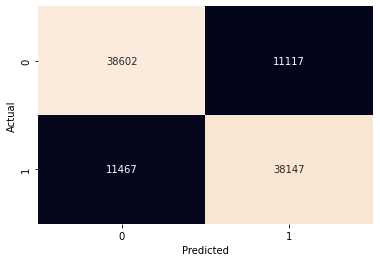

In [52]:
sns.heatmap(confusion_matrix(test.label, y_pred), annot=True, fmt='.0f', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
print(classification_report(test.label, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77     49719
           1       0.77      0.77      0.77     49614

    accuracy                           0.77     99333
   macro avg       0.77      0.77      0.77     99333
weighted avg       0.77      0.77      0.77     99333



# Comparaison avec un modèle tensorflow avec une couche embedding

In [54]:
y_pred = (model_lemm_w2v.predict(xtest_lemm)>0.5)*1
conf_matrix = confusion_matrix(test.label, y_pred)
conf_matrix = pd.DataFrame(conf_matrix).rename_axis(index = ['Actual'], columns=['predicted'])
conf_matrix

3105/3105 [==============================] - 4s 1ms/step


predicted,0,1
Actual,,
0,38083,11636
1,12617,36997


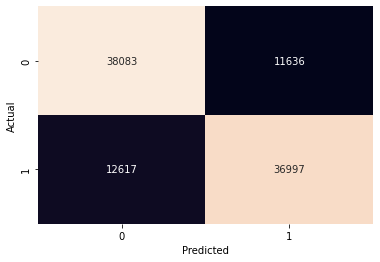

In [55]:
sns.heatmap(confusion_matrix(test.label, y_pred), annot=True, fmt='.0f', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
print(classification_report(test.label, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     49719
           1       0.76      0.75      0.75     49614

    accuracy                           0.76     99333
   macro avg       0.76      0.76      0.76     99333
weighted avg       0.76      0.76      0.76     99333

